<h1 align=center><font size = 5>SHOULD WE MOVE TO WHICH PART OF TORONTO?</font></h1>

### PROJECT DESCRIPTION

Let's imagine that you have a great new job that can boost up your career! 

BUT... That new job is requiring you to move to Toronto, Canada - a new country, new culture, new everything for you - to start a new life. How can you ensure that you will be fine when living there? Do you able to pay the house price for your family, school fees for your children? What's the weather there? The crime rates? The social life?

This project would help you to make a better decision on choosing the best place that suits you and your family. It helps you by providing a lot of information about Toronto, including the neighborhoods, the most common venues in each of those places, the average household income, renovation fees, etc.

By leveraging K-mean clustering unsupervised machine learning algorithm, all the venues belong to 2 neighborhoods - which we will choose randomly - will be categorized and displayed on the map. From that, you can easily distinguish the differences between the 2 places, as well as the similarities between them, to support you giving the best decision!

### DATA SETS

2 data sets will be used to get more information about Toronto & its neighborhood

1. Foursquare API: <br/>
According to Wikipedia: <i>"Foursquare is a local search-and-discovery service mobile app which provides search results for its users. The app provides personalized recommendations of places to go to near a user's current location based on users' "previous browsing history, purchases, or check-in history""</i>
We can leverage Foursquare's API to gather detailed information about a place, its venues, its photos & many more related tips.

2. NextHome's website: <br/>
https://nexthome.ca/ <br/>
We can find apartments, homes or condos for rent or for sale in Canada with this website. It also provides other knowledge about a specific place and its related information, including: Average Household Income, Average Renovation Cost, Overall Age of Housing, Top 3 Popular Languages and many other valuable things.

<b>How they will be used?</b> <br/>
- We need to register to Foursquare in order to use its API. 
- Once we have the access keys, we can use them to retrieve information about various neighborhoods in Toronto.
- Then, build a map of Toronto with neighborhoods superimposed on top.
- Use K-Mean to clustering places into various clusters.
- Together with data from NextHome website, we then build a comprehensive information about places in Toronto.
- Visualize the data to give a better understanding
- And finally, make a conclusion!

### API & LIBRARIES

- <b>Foursquare API</b>: to gather information about any place in the world.
- <b>NumPy</b>: a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- <b>Pandas</b>: a library for data manipulation and analysis.
- <b>Geopy</b>: to locate the coordinates of addresses, cities, countries, and landmarks across the globe.
- <b>Requests</b>: a library to handle http requests
- <b>Matplotlib</b>: for embedding plots into applications.
- <b>Sklearn</b>: a machine learning library with various classification, regression and clustering algorithms.
- <b>Folium</b>: a map rendering library.

## PART 1. GENERATE THE CLUSTERING MAP OF DOWNTOWN, TORONTO

## 1. Download & Install required libraries

In [5]:
#!conda install -c anaconda beautifulsoup4 --yes # Install BeautifulSoup4 (for scraping web content)
print('BeautifulSoup installed')

BeautifulSoup installed


In [7]:
#!conda install -c conda-forge geopy --yes  #uncomment this line to install this package
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print ('Geopy installed')

Geopy installed


In [9]:
#!conda install -c conda-forge folium=0.5.0 --yes #uncomment this line to install this package
import folium # map rendering library
print ('Folium installed')

Folium installed


### Import required libraries

In [10]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## 2. Download HTML content to a dataframe

In [11]:
from bs4 import BeautifulSoup

html_source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(html_source, 'lxml') #convert to Soup format

In [12]:
#Get data from the Toronto table
toronto_table = soup.find('table', class_='wikitable sortable')

In [13]:
#Define lists to store required information
postalcodes=[]
boroughs=[]
neighborhoods=[]

# Fill data from toronto_table to dataframe
for row in toronto_table.find_all('tr'):
    cells = row.find_all('td')
    if (len(cells) != 0): #to skip empty content
        
        postalcode = cells[0].text.strip() #strip() function to remove '\n' character
        borough = cells[1].text.strip()
        neighborhood = cells[2].text.strip()
        
        if(borough != 'Not assigned'): # to skip row which has BOROUGH = 'Not assigned'
            #get individual value
            postalcodes.append(postalcode) 
            boroughs.append(borough)
            neighborhoods.append(neighborhood)

#Assign values to a dataframe
toronto_df = pd.DataFrame({'PostalCode':postalcodes, 'Borough':boroughs, 'Neighborhood':neighborhoods})

toronto_df.head(20)
        

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


## 3. Manipulate the dataframe

In [14]:
# First, get all unique Postal Code
u_postalcodes = toronto_df['PostalCode'].unique()
u_postalcodes = u_postalcodes.tolist() # convert to Python list from Numpy array

In [15]:
# Secondly, get all Borough(s) corresponded to those PostalCodes above
u_boroughs = []
for pc in u_postalcodes:
    u_boroughs.append(toronto_df[toronto_df.PostalCode == pc]['Borough'].unique().tolist()[0])

In [16]:
# Thirdly, concatenate all Neighborhoods related to the PostalCodes 
u_neighborhoods = []
for pc in u_postalcodes:
    all_neighborhoods = toronto_df[toronto_df.PostalCode == pc]['Neighborhood'].tolist()
    temp = ''
    for nbh in all_neighborhoods:
        temp += nbh + ', '
    
    u_neighborhoods.append(temp[0:len(temp)-2]) # -2 to remove the ' ,' term
    
#u_neighborhoods

In [17]:
# Reconstruct our dataframe
toronto_df = pd.DataFrame({'PostalCode':u_postalcodes, 'Borough':u_boroughs, 'Neighborhood':u_neighborhoods})
toronto_df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [18]:
# Get all neiborhood which has value = 'Not assigned'
toronto_df[toronto_df.Neighborhood == 'Not assigned']

# Since there's only 1 record which has Neighborhood = 'Not assigned', we can fix our dataframe easily:
toronto_df.at[4, 'Neighborhood'] = "Queen's Park"

## 4. Finally, here's our dataframe

In [19]:
# Finally, here's our dataframe
toronto_df.head(20)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


## 5. Add Latitude & Longitude

In [20]:
# Load latitude & longitude from CSV

geo_df = pd.read_csv('https://cocl.us/Geospatial_data')
print('Loaded')

Loaded


In [21]:
# Rename columns of geo_df
geo_df.columns = ['PostalCode', 'Latitude', 'Longitude']

# Get latitude & longitude corresponded to our PostalCode
latitudes = []
longitudes = []

for u in u_postalcodes:
    latitudes.append(geo_df[geo_df.PostalCode == u]['Latitude'].tolist()[0])
    longitudes.append(geo_df[geo_df.PostalCode == u]['Longitude'].tolist()[0])

### Our new Dataframe

In [22]:
updated_toronto_df = toronto_df.copy()
updated_toronto_df['Latitude'] = latitudes
updated_toronto_df['Longitude'] = longitudes

updated_toronto_df.head(20)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


## 6. Neighborhoods in Toronto

#### Use geopy library to get the latitude and longitude values of Toronto, Ontario

In [23]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
tor_latitude = location.latitude
tor_longitude = location.longitude
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(tor_latitude, tor_longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto, Ontario are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [24]:
# Copy to preserve our old dataframe
new_df = updated_toronto_df.copy()
#new_df

In [25]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=10)

# add markers to map
for lat, lng, bor, neigh in zip(new_df['Latitude'], new_df['Longitude'], new_df['Borough'], new_df['Neighborhood']):
    label = '{}, {}'.format(neigh, bor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Choose Downtown Toronto for clustering neighborhoods

In [26]:
down_toronto_data = new_df[new_df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
down_toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [27]:
# Let's get the geographical coordinates of Downtown Toronto
address = 'Downtown Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
dt_latitude = location.latitude
dt_longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(dt_latitude, dt_longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Downtown Toronto are 43.655115, -79.380219.


In [28]:
# let's visualize Downtown Toronto the neighborhoods in it.

map_dt_toronto = folium.Map(location=[dt_latitude, dt_longitude], zoom_start=13)

# add markers to map
for lat, lng, bor, neigh in zip(down_toronto_data['Latitude'], down_toronto_data['Longitude'], down_toronto_data['Borough'], down_toronto_data['Neighborhood']):
    label = '{}, {}'.format(neigh, bor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dt_toronto)  
    
map_dt_toronto

#### Define Foursquare Credentials and Version

In [29]:
CLIENT_ID = 'PFP4CVE30FLILZH0HUSDVPYZQYRTSGPYZAYZXU5X5X2YO5V5' # your Foursquare ID
CLIENT_SECRET = '3D0NBBKA5PEZH1BLEMBJABXFJOIHAERDGOVS25OBJVNTKTPC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PFP4CVE30FLILZH0HUSDVPYZQYRTSGPYZAYZXU5X5X2YO5V5
CLIENT_SECRET:3D0NBBKA5PEZH1BLEMBJABXFJOIHAERDGOVS25OBJVNTKTPC


#### Let's create a function to repeat the same process to all the neighborhoods in Downtown Toronto

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    radius = 500
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *downtown_venues*.

In [31]:
# type your answer here
downtown_venues = getNearbyVenues(names=down_toronto_data['Neighborhood'],
                                   latitudes=down_toronto_data['Latitude'],
                                   longitudes=down_toronto_data['Longitude']
                                  )

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
First Canadian Place, Underground city
Church and Wellesley


In [32]:
# Let's check the size of the resulting dataframe

print(downtown_venues.shape)
downtown_venues.head()

(1280, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront, Regent Park",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Harbourfront, Regent Park",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Harbourfront, Regent Park",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
3,"Harbourfront, Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Harbourfront, Regent Park",43.65426,-79.360636,Cooper Koo YMCA,43.653191,-79.357947,Gym / Fitness Center


Let's check how many venues were returned for each neighborhood

In [33]:
downtown_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",46,46,46,46,46,46
Central Bay Street,81,81,81,81,81,81
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15
Church and Wellesley,88,88,88,88,88,88
"Commerce Court, Victoria Hotel",100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [34]:
print('There are {} uniques categories.'.format(len(downtown_venues['Venue Category'].unique())))

There are 203 uniques categories.


## Analyze Each Neighborhood


In [35]:
# one hot encoding
toronto_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# and because there's already existed a venue named 'Neighborhood', I have to change the column name
toronto_onehot['Neighborhood2'] = downtown_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood2,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [36]:
toronto_onehot.shape

(1280, 204)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
toronto_grouped = toronto_onehot.groupby('Neighborhood2').mean().reset_index()
toronto_grouped

,Neighborhood2,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.010000,0.010000,0.000000,0.02,0.00,0.000000,0.000000,0.020000,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.020000,0.000000,0.000000,0.00,0.020000,0.010000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.00000,0.020000,0.010000,0.070000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.030000,0.000000,0.000000,0.020000,0.010000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.01,0.00000,0.000000,0.000000,0.00,0.010000,0.00,0.020000,0.000000,0.000000,0.01,0.00,0.000000,0.01,0.00,0.010000,0.000000,0.030000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.030000,0.00,0.010000,0.010000,0.00,0.000000,0.000000,0.010000,0.020000,0.010000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.010000,0.000000,0.00,0.010000,0.000000,0.000000,0.00,0.0

#### Let's confirm the new size

In [38]:
toronto_grouped.shape

(18, 204)

#### Let's print each neighborhood along with the top 5 most common venues

In [39]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood2']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood2'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.06
2           Steakhouse  0.04
3  American Restaurant  0.04
4      Thai Restaurant  0.04


----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.05
2          Café  0.04
3   Cheese Shop  0.04
4    Steakhouse  0.04


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.14
1  Airport Terminal  0.14
2   Airport Service  0.14
3          Boutique  0.07
4  Sculpture Garden  0.07


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.09
1   Restaurant  0.09
2       Bakery  0.04
3       Market  0.04
4          Pub  0.04


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.15
1                 Café  0.07
2   Italian Restaurant  0.05
3         Burger Joint  0.04
4  Japanese Restaurant  0.04

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood2']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,American Restaurant,Restaurant,Bar,Hotel,Cosmetics Shop,Gym
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Beer Bar,Seafood Restaurant,Farmers Market,Bakery,Cheese Shop,Café
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Airport Service,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Plane,Airport Gate,Airport
3,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Pub,Indian Restaurant,Italian Restaurant,Bakery,Pizza Place,Market,Café,Park
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Bar,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Ice Cream Shop,Falafel Restaurant
5,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Dumpling Restaurant,Grocery Store
6,Christie,Grocery Store,Café,Park,Baby Store,Italian Restaurant,Diner,Nightclub,Convenience Store,Restaurant,Coffee Shop
7,Church and Wellesley,Japanese Restaurant,Coffee Shop,Burger Joint,Gay Bar,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Men's Store,Pub,Café
8,"Commerce Court, Victoria Hotel",Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Italian Restaurant,Deli / Bodega,Gastropub,Steakhouse,Gym
9,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Hotel,Café,American Restaurant,Deli / Bodega,Gastropub,Restaurant,Sports Bar,Gym,Italian Restaurant


## Cluster Neighborhoods


Run *k*-means to cluster the neighborhood into 5 clusters.

In [42]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood2', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 3, 4, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [43]:
toronto_merged = down_toronto_data

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Café,Mexican Restaurant,Breakfast Spot,Restaurant,Pub,Theater,Brewery
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Bar,Japanese Restaurant,Pizza Place,Tea Room,Middle Eastern Restaurant,Italian Restaurant
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Restaurant,Clothing Store,Hotel,Cocktail Bar,Gastropub,Bakery,Italian Restaurant,Cosmetics Shop
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Beer Bar,Seafood Restaurant,Farmers Market,Bakery,Cheese Shop,Café
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Bar,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Ice Cream Shop,Falafel Restaurant


## Finally, let's visualize the resulting clusters

In [45]:
# create map
map_clusters = folium.Map(location=[dt_latitude, dt_longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## PART 2. ANALYZE CLUSTERS

## 1. Our venues belong to which Neighborhood?

In [46]:
#Get all information belongs to Cluster 1, together with Neighborhood
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster1.shape

(13, 12)

In [47]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster2.shape

(1, 12)

In [48]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster3.shape

(1, 12)

In [49]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster4.shape

(2, 12)

In [50]:
cluster5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster5.shape

(1, 12)

### Merge all clusters' neighborhood names into a new dataframe

In [51]:
downtown_clusters=pd.DataFrame({"Cluster1":cluster1["Neighborhood"],
                      "Cluster2":cluster2["Neighborhood"],
                      "Cluster3":cluster3["Neighborhood"],
                      "Cluster4":cluster4["Neighborhood"],
                    "Cluster5":cluster5['Neighborhood']})

In [52]:
downtown_clusters

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5
0,"Harbourfront, Regent Park",NaN,NaN,NaN,NaN
1,"Ryerson, Garden District",NaN,NaN,NaN,NaN
2,NaN,NaN,St. James Town,NaN,NaN
3,Berczy Park,NaN,NaN,NaN,NaN
4,Central Bay Street,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,Christie,NaN
6,NaN,NaN,NaN,NaN,"Adelaide, King, Richmond"
7,"Harbourfront East, Toronto Islands, Union Station",NaN,NaN,NaN,NaN
8,"Design Exchange, Toronto Dominion Centre",NaN,NaN,NaN,NaN
9,"Commerce Court, Victoria Hotel",NaN,NaN,NaN,NaN


#### Randomly, we can take 2 neighborhoods, to deal with our problem. Clearly to see <b>'Cabbagetown'</b> and <b>'Central Bay Street'</b> are in a same cluster. So, we need to gather more information to compare these 2 neighborhoods!

## 2. Gather more information about <b>Cabbagetown</b> and <b>Central Bay Street</b>

According to these 2 pages below, we can get more information about the 2 neighborhoods: <br/>
About Cabbagetown: https://nexthome.ca/neighbourhoods/toronto-cabbagetown/30124/#housing <br/>
and Central Bay Street: https://nexthome.ca/homes-for-rent/on/toronto/bay-street-corridor/#neighbourhood-demographics

We will try to generate some graphics based on the information that we gathered on the 2 websites above: <br/>
About <b>Cabbagetown</b>: <br/>
Average Reno Cost: 999 USD <br/>
Average Household Income: 99578 USD <br/>
University Education Levels: 50% <br/>
Percentage of income that more than 50,000 USD/year: 48% <br/><br/>

About <b>Bay Street Corridor</b>: <br/>
Average Reno Cost: 9999 USD <br/>
Average Household Income: 92055 USD <br/>
University Education Levels: 68% <br/>
Percentage of income that more than 50,000 USD/year: 55% 

## 3. Build a dataframe about <b>Cabbagetown</b> and <b>Bay Street Corridor</b> 

In [53]:
places = ['Cabbagetown', 'Bay Street Corridor']
renocost = [999/30, 9999/30] #Divide these values by 10 for better visualization later
householdincome = [99578/70, 92055/70] #Divide these values by 50 for better visualization later
unilevel = [50, 68]
income50k = [48, 55]

new_toronto = pd.DataFrame({'Neighborhood':places, 'Reno Cost':renocost, 'Household Income':householdincome,
                            'Percentage of University degree': unilevel, 'Percentage of income more than 50k': income50k})

#Reset index for easier visualization
new_toronto=new_toronto.set_index("Neighborhood",drop=True)
new_toronto

,Reno Cost,Household Income,Percentage of University degree,Percentage of income more than 50k
Neighborhood,,,,
Cabbagetown,33.3,1422.542857,50,48
Bay Street Corridor,333.3,1315.071429,68,55


## 4. Generate visualization

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

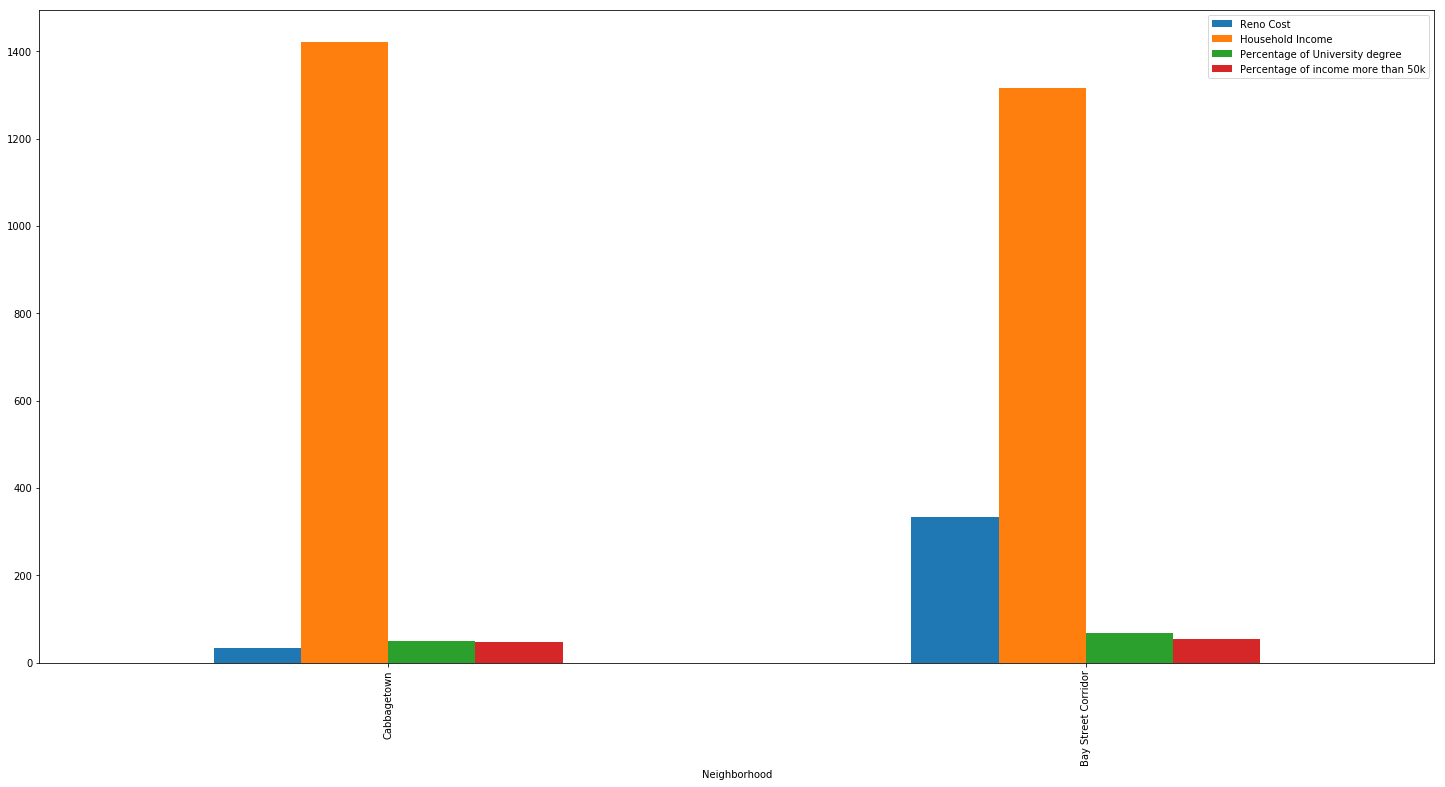

In [55]:
new_toronto.plot(kind='bar',figsize=(25,12))
plt.show()

## 5. Conclusion

#### <i> This analysis concludes that Cabbagetown has the significant lower renovation cost and higher average income than Bay Street Corridor. Despite the percentage of people who has bachelor degree in Bay Street is slightly higher than Cabbagetown, as well as the percentage of population that belongs to the middle-class is higher too; living in Cabbagetown is definitely more than reasonable!  <br/> <b>Hence, Cabbagetown wins over Bay Street Corridor for most of people!!!</b>
</i>

### THANK YOU! :)